# Figures S3 and S4: Surface fluxes and density transformation due to surface fluxes

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
from gsw import SA_from_SP, p_from_z, alpha, beta
import matplotlib.path as mpath
import sys
sys.path.append(
    "/g/data/e14/cs6673/Ross_salinity/Python_scripts_published/") 
from Info_definitions import (
    path_database, path_plots, exptdict, shelf_mask_isobath,
    yearly_mean)

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import string

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34713/status,
Dashboard: /proxy/34713/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44121,Workers: 7
Dashboard: /proxy/34713/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:45111,Total threads: 4
Dashboard: /proxy/39087/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:38327,


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23428348274496 and this is thread id 23426745104128.
Exception closing connection <sqlite3.Connection object at 0x154e469f2a40>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

## Load data

In [4]:
%%time
ekeys = ['ctrl', 'wind_50_down_zonal', 'mw_50_down']

start_time = '2150-01-01'
end_time = '2159-12-31'

ht = cc.querying.getvar(
    exptdict['ctrl']['expt'], 'ht',
    session=cc.database.create_session(), n=1).sel(
    yt_ocean=slice(-90, -60))
ht_shelf, shelf_mask = shelf_mask_isobath(ht, output_mask=True)
land_mask = (ht*0).fillna(1)

for ekey in ekeys:
    print(ekey)
    e = exptdict[ekey]
    if ekey == 'ctrl':
        session = cc.database.create_session()
    else:
        db = (path_database + e['expt'] + '.db')
        session = cc.database.create_session(db)

    SST = cc.querying.getvar(
        e['expt'], 'temp', session, frequency='1 monthly',
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).isel(st_ocean=0).sel(
            yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150)) - 273.15
        
    net_sfc_heating = (
        cc.querying.getvar(
            e['expt'], 'sfc_hflux_from_runoff', session, start_time=start_time,
            end_time=end_time, ncfile='ocean_month.nc',
            chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}) +
        cc.querying.getvar(
            e['expt'], 'sfc_hflux_coupler', session, start_time=start_time, 
            end_time=end_time, ncfile='ocean_month.nc',
            chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}) +
        cc.querying.getvar(
            e['expt'], 'sfc_hflux_pme', session, start_time=start_time,
            end_time=end_time, ncfile='ocean_month.nc',
            chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}) +
        cc.querying.getvar(
            e['expt'], 'frazil_3d_int_z', session, start_time=start_time,
            end_time=end_time, ncfile='ocean_month.nc',
            chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'})).sel(
            yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150))
    frazil_3d_int_z = cc.querying.getvar(
        e['expt'], 'frazil_3d_int_z', session, frequency='1 monthly',
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150))

    # compute net surface heat flux from its component terms
    e['net_surface_heating'] = net_sfc_heating + frazil_3d_int_z
    # W/m2

    pme_river = cc.querying.getvar(
        e['expt'], 'pme_river', session, frequency='1 monthly',
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150))
    # mass flux of precip - evap + river (water flux)
    sfc_salt_flux_ice = cc.querying.getvar(
        e['expt'], 'sfc_salt_flux_ice', session, frequency='1 monthly',
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150))
    # Salt flux from ice in kg/m^2/s (salt flux)
    sfc_salt_flux_restore = cc.querying.getvar(
        e['expt'], 'sfc_salt_flux_restore',  session, frequency='1 monthly',
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150))
    # Salt flux and restoring in kg/m^2/s (salt flux)

    lon_t = cc.querying.getvar(
        exptdict['ctrl']['expt'], 'geolon_t',
        session=cc.database.create_session(), n=1,
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150))
    lat_t = cc.querying.getvar(
        exptdict['ctrl']['expt'], 'geolat_t',
        session=cc.database.create_session(), n=1,
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150))

    e['salt'] = cc.querying.getvar(
        e['expt'], 'salt', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
        yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -150))

    depth = -e['salt'].st_ocean[0].values # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0+1)*depth
    pressure = p_from_z(depth_tile, lat_t)
    # convert units to absolute salinity
    SSS = SA_from_SP(e['salt'].isel(st_ocean=0), pressure, lon_t, lat_t)
    e['freshwater_fluxes'] = (
        pme_river - 1000 / SSS * (sfc_salt_flux_ice + sfc_salt_flux_restore))

    haline_contraction = beta(SSS, SST, pressure)
    salt_transformation = haline_contraction * (
        SSS * pme_river - 1000 * (sfc_salt_flux_ice + sfc_salt_flux_restore))

    thermal_expansion = alpha(SSS, SST, pressure)
    c_p = 3992.1
    heat_transformation = (
        thermal_expansion*e['net_surface_heating']/c_p)

    # this procedure defined fluxes from lighter to denser classes as
    # negative, now they are defined possitive
    e['salt_transformation'] = salt_transformation * -1
    e['heat_transformation'] = heat_transformation * -1

ctrl
wind_50_down_zonal


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23428348274496 and this is thread id 23426745104128.
Exception closing connection <sqlite3.Connection object at 0x154e469f2340>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

mw_50_down


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23428348274496 and this is thread id 23426745104128.
Exception closing connection <sqlite3.Connection object at 0x154e469f3440>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

CPU times: user 17 s, sys: 1.81 s, total: 18.8 s
Wall time: 55.5 s


In [5]:
def Fig_S3_S4(ekeys, var_all, v_max, time_slice, fig_name=None):

    fig, axs = plt.subplots(
        2, 3, figsize=(12, 6), subplot_kw={
            'projection': ccrs.PlateCarree(central_longitude=185)})
    proj = ccrs.PlateCarree()
    plt.subplots_adjust(hspace=.22, wspace=.3)

    for i, ekey in enumerate(ekeys):
        for p in range(len(var_all)):
            e = exptdict[ekey]
            if ekey == 'ctrl':
                var = e[var_all[p]].sel(time=time_slice)
            else:
                var = (e[var_all[p]] - exptdict['ctrl'][var_all[p]]).sel(
                    time=time_slice)
            var = yearly_mean(var).mean('time')
        
            axs[p, i].contourf(land_mask.xt_ocean, land_mask.yt_ocean,
                        land_mask, colors='silver', levels=[0.5, 2],
                        zorder=2, transform=proj)
            axs[p, i].set_extent([162, 205, -79, -70])
            gl = axs[p, i].gridlines(draw_labels=False)
            gl.xlocator = mticker.FixedLocator(
                [180, -160])
            if p == 1:
                axs[p, i].set_xticks([180, -160], crs=proj)
                axs[p, i].xaxis.set_major_formatter(LongitudeFormatter(
                    dateline_direction_label=True))
            gl.ylocator = mticker.FixedLocator(
                np.arange(-75, -65, 5))
            if i == 0:
                axs[p, i].set_yticks(np.arange(-75, -65, 5), crs=proj)
                axs[p, i].yaxis.set_major_formatter(LatitudeFormatter())
            axs[p, i].set_ylim(-79, None)
            axs[p, i].set_aspect('auto')
        
            axs[p, i].contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask,
                        levels=[0, 1], colors = 'k',  transform=proj)
            if var_all[0][-14:] == 'transformation':
                c_map = cmo.balance
            else:
                c_map = cmo.balance_r
            pc = axs[p, i].pcolormesh(
                var.xt_ocean, var.yt_ocean, var, cmap=c_map, vmin=-v_max[i][p],
                vmax=v_max[i][p], transform=proj)
            if ekey == 'ctrl':
                axs[p, i].set_title(string.ascii_lowercase[p*3+i] + ') ' + e['expt_str'],
                                    fontweight='bold', loc='left')
            else:
                axs[p, i].set_title(
                    string.ascii_lowercase[p*3+i] + ') ' + e['expt_str'] +
                    '  -  ' + exptdict['ctrl']['expt_str'],
                    fontweight='bold', loc='left')
            
            pos = axs[p, i].get_position()
            cax = plt.axes([pos.xmax+.01, pos.ymin,
                            0.013, pos.ymax-pos.ymin])
            cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
            if var_all[p] == 'net_surface_heating':
                unit = 'W m$^{-2}$'
            elif var_all[p] == 'freshwater_fluxes':
                unit = 'kg m$^{-2}$ s$^{-1}$'
            else:
                unit = 'm s$^{-1}$'
            cb.ax.set_title(unit)
            if v_max[i][p] < 1:
                cb.formatter.set_powerlimits((0, 0))
                
    if fig_name != None:
        plt.savefig(path_plots + fig_name, dpi=300, bbox_inches="tight")
    plt.show()

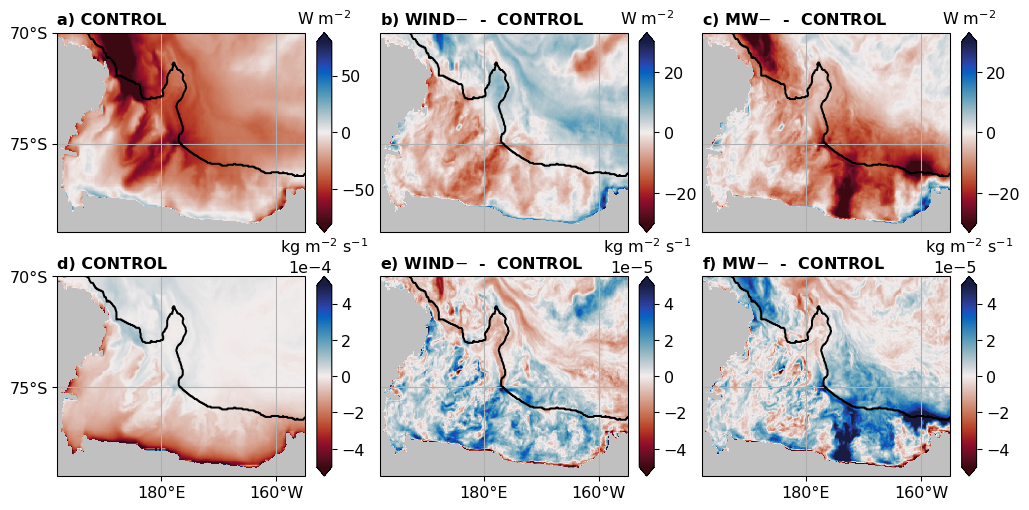

In [6]:
time_slice = slice('2155-01', '2159-12')
var_all = ['net_surface_heating', 'freshwater_fluxes']
v_max = [[80, 5e-4], [30, 5e-5], [30, 5e-5]]
fig_name = 'FigS3.png'
Fig_S3_S4(ekeys, var_all, v_max, time_slice, fig_name)

In [7]:
# explanation to Figure above: heat and freshwater fluxes
# top row: for control red colors depict heat loss to the atmosphere -> surface density gain
# and red colors in anomaly plots show more heat loss/ increased density gain in perturbation expts.
# bottom row: for control red colors depict freshwater flux out of the ocean (e.g. due to sea ice 
# formation) -> surface density gain
# and red colors in anomaly plots show more freshwater being removed (due to e.g. more sea ice 
# formation) / increased density gain in perturbation experiments, while blue colors depict
# less freshwater being removed / reduced density gain in perturbation experiments

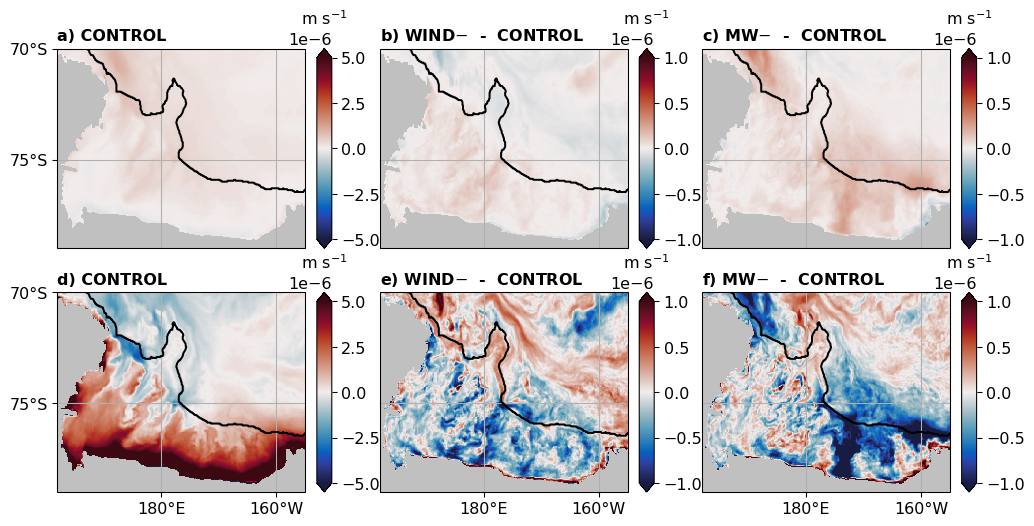

In [8]:
time_slice = slice('2155-01', '2159-12')
var_all = ['heat_transformation', 'salt_transformation']
v_max = [[5e-6, 5e-6], [1e-6, 1e-6], [1e-6, 1e-6]]
fig_name = 'FigS4.png'
Fig_S3_S4(ekeys, var_all, v_max, time_slice, fig_name)

In [9]:
# explanation to Figure above: density transformation due to heat and freshwater fluxes
# top row: for control red colors depict surface density gain due to heat loss to the atmosphere
# and red colors in anomaly plots show increased surface density gain due to more heat loss
# in perturbation expts. However the density transformation due to heat fluxes is about an
# order of magnitude smaller than the density transformation due to salt fluxes
# bottom row: for control red colors depict surface density gain due to freshwater flux out of the
# ocean (e.g. due to sea ice  formation)
# and red colors in anomaly plots show increased density gain due to more freshwater being removed
# (due to e.g. more sea ice formation) in perturbation experiments, while blue colors depict
# reduced density gain in perturbation experiments due to freshwater fluxes and this overall dominates
# especially in WIND- implying that changes in surface fluxes do not contribute to increasing the density
# in the polynya regions, increased density gain due to FW fluxes is only evident along the coast
# in the southern Ross Sea but this is likely a local feedback triggered by the waves propagating through.